# 후행품목 무역량 예측

## 데이터 불러오기

In [ ]:
# 품목 간 선후행 관계가 존재하는 공행성 쌍(A → B)을 찾고,
# 선행 품목(A)의 흐름을 활용해 후행 품목(B)의 다음달의 총 무역량(value)을 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/후행품목 무역량 예측/train.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/후행품목 무역량 예측/sample_submission.csv')

## 데이터 살펴보기

In [ ]:
data.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


In [ ]:
sample_sub.head(3)

,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,999999999
1,DEWLVASR,AHMDUILJ,999999999
2,DEWLVASR,XIPPENFQ,999999999


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


In [ ]:
# 100개의 아이템
data['item_id'].value_counts()

,count
item_id,
ELQGMQWE,129
AHMDUILJ,129
XIPPENFQ,129
VWMBASNE,129
OJIFIHMZ,129
...,...
TANNMIMB,9
GIKPEWTY,8
RUVXNNVA,6


In [ ]:
data.describe()

,year,month,seq,type,hs4,weight,quantity,value
count,10836.000000,10836.000000,10836.000000,10836.0,10836.000000,1.083600e+04,1.083600e+04,1.083600e+04
mean,2023.331395,6.108435,2.034238,1.0,4821.969546,1.098413e+06,8.633771e+04,1.739442e+06
std,1.049357,3.392649,0.813380,0.0,2296.892536,5.153790e+06,7.614669e+06,5.457480e+06
min,2022.000000,1.000000,1.000000,1.0,1210.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.000000,3.000000,1.000000,1.0,2833.000000,3.457500e+02,0.000000e+00,1.150675e+04
50%,2023.000000,6.000000,2.000000,1.0,3824.000000,6.532500e+03,0.000000e+00,1.250070e+05
75%,2024.000000,9.000000,3.000000,1.0,7202.000000,1.555108e+05,0.000000e+00,1.039764e+06
max,2025.000000,12.000000,3.000000,1.0,9403.000000,1.104919e+08,7.925990e+08,1.110414e+08


In [ ]:
# type 변수는 전부 1로 되어있음 -> 변수제거
data.drop('type', axis=1, inplace=True)

In [ ]:
# na값 없음
data.isna().sum()

,0
item_id,0
year,0
month,0
seq,0
hs4,0
weight,0
quantity,0
value,0


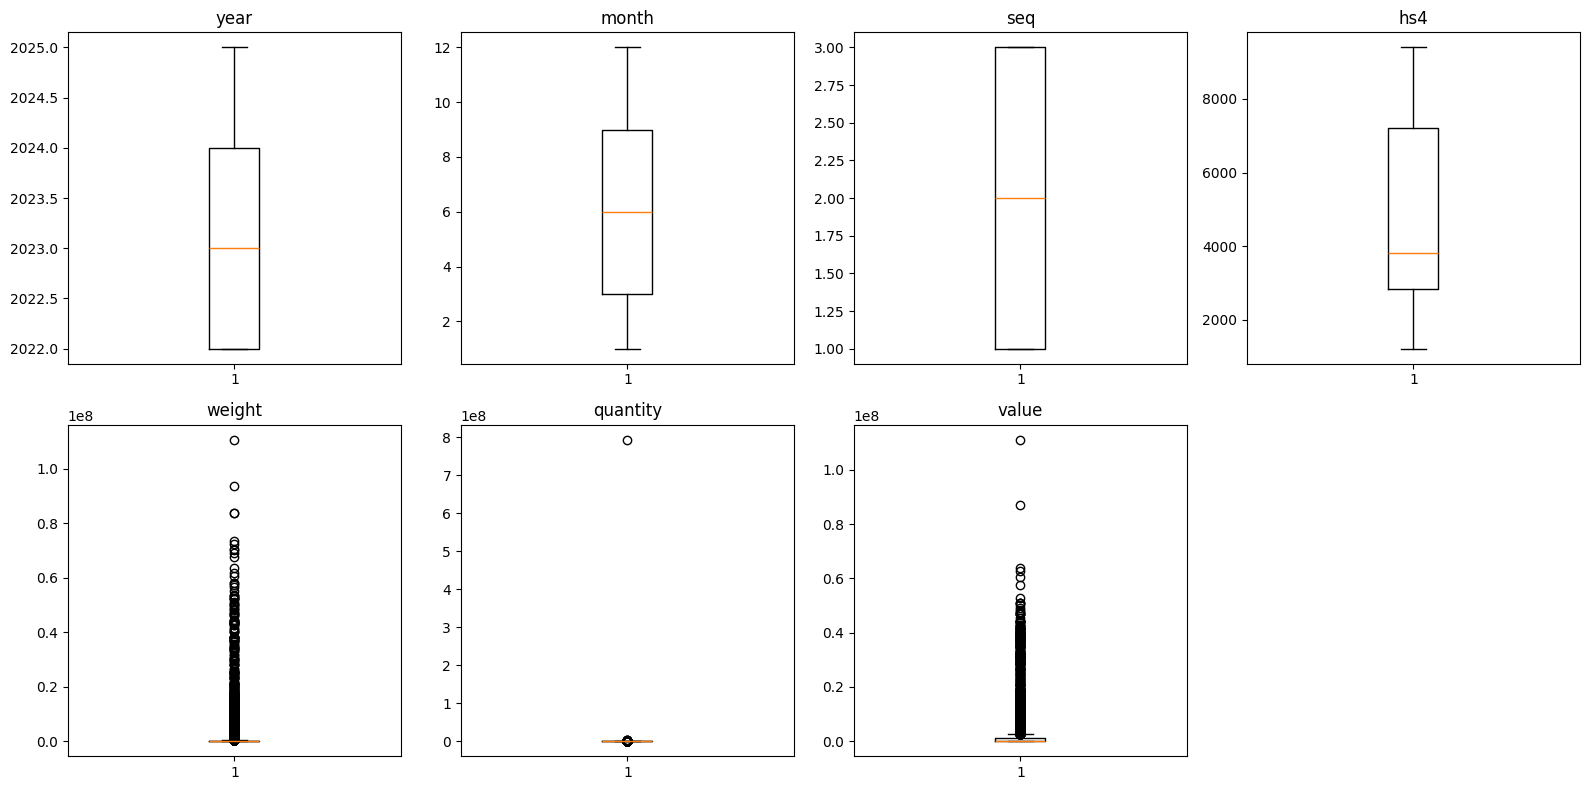

In [ ]:
# 각 변수 박스플롯 시각화
import matplotlib.pyplot as plt

# item_id 제외
cols = data.columns.drop('item_id')

n_rows = 2
n_cols = 4

plt.figure(figsize=(16, 8))

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.boxplot(data[col])
    plt.title(col)

plt.tight_layout()
plt.show()



## 날짜 데이터 만지기


In [ ]:
# 날짜는 연도와 월을 하나로 합쳐줌
# 공행성을 한달 기준으로 볼거기떄문에 날짜를 한달로 맞춰 seq도 빼준다.
import pandas as pd

data['date'] = pd.to_datetime(
    data['year'].astype(str) + '-' +
    data['month'].astype(str).str.zfill(2)
)

data.drop(['year', 'month', 'seq'], axis=1, inplace=True)


In [ ]:
# 아이템,월별로 집계
import pandas as pd

# 1) 날짜를 datetime으로 변환
data['date'] = pd.to_datetime(data['date'])

# 2) item_id + 월별로 value 합계
monthly = (
    data.groupby(['item_id', pd.Grouper(key='date', freq='ME')])['value']
      .sum()
      .reset_index()
)


In [ ]:
# 중간중간에 무역내역이 없어 날짜를 건너뛰는 달은 0으로 채운다.
def make_full_monthly(df):
    """
    df: monthly[item_id==XXX] 형태 (date, value)
    date: 월말 timestamp
    """
    df = df.sort_values("date")
    start = df["date"].min()
    end = df["date"].max()

    full = pd.DataFrame({"date": pd.date_range(start, end, freq="ME")})
    df_full = full.merge(df, on="date", how="left").fillna(0)
    return df_full

full_monthly = []
for item in monthly["item_id"].unique():
    tmp = monthly[monthly["item_id"] == item][["item_id", "date", "value"]]
    tmp2 = make_full_monthly(tmp)
    tmp2["item_id"] = item
    full_monthly.append(tmp2)

monthly = pd.concat(full_monthly)


## ccf

In [ ]:
import pandas as pd
import numpy as np

def item_pair(item_a, item_b, monthly, max_lag=6):
    # 1) 각 item의 월별 시계열
    sA = (monthly[monthly['item_id'] == item_a]
          .set_index('date')['value']
          .sort_index())

    sB = (monthly[monthly['item_id'] == item_b]
          .set_index('date')['value']
          .sort_index())

    # 2) 날짜 align
    pair = pd.concat([sA, sB], axis=1, join='inner')
    pair.columns = ['A', 'B']
    pair = pair.dropna()

    # 공통 기간이 없으면 NaN 리턴
    if len(pair) == 0:
        return pd.DataFrame([{
            'a': item_a,
            'b': item_b,
            'lag': np.nan,
            'corr': np.nan
        }])

    results = []

    # 3) lag별 CCF 계산
    for lag in range(-max_lag, max_lag + 1):
        shifted_B = pair['B'].shift(-lag)   # corr(A_t, B_{t+lag})

        tmp = pd.concat([pair['A'], shifted_B], axis=1).dropna()
        # 월별 3년 + lag±6이면 사실 필요 없지만, 혹시 몰라 안전장치
        if len(tmp) < 3:
            continue

        corr = tmp.iloc[:, 0].corr(tmp.iloc[:, 1])
        results.append({'lag': lag, 'corr': corr})

    # 유효한 lag가 하나도 없으면 NaN 리턴
    if len(results) == 0:
        return pd.DataFrame([{
            'a': item_a,
            'b': item_b,
            'lag': np.nan,
            'corr': np.nan
        }])

    result = pd.DataFrame(results)

    # 절댓값 기준으로 가장 큰 상관과 그 lag 찾기
    best_idx = result['corr'].abs().idxmax()
    best_row = result.loc[best_idx]
    best_lag = best_row['lag']
    best_corr = best_row['corr']

    # DF로 반환
    return pd.DataFrame([{
        'a': item_a,   # 여기서는 "입력 순서 기준" (나중에 lag 보고 진짜 선행/후행 재정의)
        'b': item_b,
        'lag': best_lag,
        'corr': best_corr
    }])


In [ ]:
results = []  # 빈 리스트 준비

items = data['item_id'].unique()

for i in range(len(items)-1):
    for j in range(i+1, len(items)):

        item_a = items[i]
        item_b = items[j]

        df_pair = item_pair(item_a, item_b, monthly)  # 한 줄짜리 DF

        results.append(df_pair)  # 리스트에 DF append

# 반복 끝난 뒤, 모두 합치기
final_ccf_df = pd.concat(results, ignore_index=True)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:292

In [ ]:
# NaN은 두 아이템은 함께 움직였다고 할 수 없음 (분석 제외 대상)
# lag이 0인것도 제외
print(final_ccf_df.isna().sum())
final_ccf_df.dropna(inplace=True)
final_ccf_df = final_ccf_df[final_ccf_df['lag'] != 0]

a         0
b         0
lag     109
corr    109
dtype: int64


In [ ]:
# corr의 절댓값이 0.3 이상인것을 공행성이 있다고 판단
final_ccf_df = final_ccf_df[abs(final_ccf_df['corr']) >= 0.33]

In [ ]:
# 선행성 정리 테이블 생성
relations = []

for _, row in final_ccf_df.iterrows():
    a, b, lag = row['a'], row['b'], row['lag']

    if lag > 0:
        relations.append({'leader': a, 'follower': b, 'lag': abs(lag)})
    elif lag < 0:
        relations.append({'leader': b, 'follower': a, 'lag': abs(lag)})

relations_df = pd.DataFrame(relations)


In [ ]:
# ccf 저장
relations_df.to_csv('/content/drive/MyDrive/Colab Notebooks/후행품목 무역량 예측/relations_df.csv', index=False)

## 8월 무역량 예측

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pandas as pd
# relations_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/후행품목 무역량 예측/relations_df.csv')

In [ ]:
# follower를 예측하기 위한 변수 dict 만들기
from collections import defaultdict

followers = defaultdict(list)

for _, row in relations_df.iterrows():
    leader = row['leader']
    follower = row['follower']
    lag = row['lag']

    followers[follower].append((leader, lag))


In [ ]:
def build_training_df(follower, monthly, followers_dict, min_rows=6):
    """
    특정 follower(item_id) 예측을 위한 학습 데이터프레임 생성.

    monthly: item_id, date, value 포함된 DF
    followers_dict: {follower: [(leader, lag), ...]}
    min_rows: 최소 학습 행 개수
    """

    # (1) follower의 원본 시계열 (target)
    df = monthly[monthly["item_id"] == follower][["date", "value"]].copy()
    df = df.rename(columns={"value": "target"})

    if len(df) == 0:
        return None  # 데이터 자체가 없으면 학습 불가

    relations = followers_dict.get(follower, [])


    lag_list = []
    # (2) leader들의 lagged feature 추가
    for leader, lag in relations:
        s = monthly[monthly["item_id"] == leader][["date", "value"]].copy()

        # 이 feature 이름이 모델 입력 변수 이름이 됨
        colname = f"{leader}_lag{lag}"

        # lag 적용: leader가 선행하므로 → follower 시점으로 맞추기 위해 앞으로 당기기
        s["date"] = s["date"] + pd.DateOffset(months=lag)
        s = s.rename(columns={"value": colname})

        # left join
        df = df.merge(s, on="date", how="left")

        # 최대 lag
        lag_list.append(lag)
        max_lag = int(max(lag_list))

    # (3) 날짜순 정렬 후,lag으로 밀린 행, 결측값 대치
    df = df.sort_values("date")
    df = df.iloc[max_lag:]
    df = df.fillna(0)

    # (4) 학습 가능한 데이터가 충분한지 확인
    if len(df) < min_rows:
        return None

    return df


In [ ]:
import pandas as pd

def build_predict_row(follower, monthly, followers_dict, forecast_month):
    """
    특정 follower에 대해 forecast_month(예: 2025-08-31)에 대한
    입력용 feature row 1개 생성.
    target은 없음.
    """
    relations = followers_dict.get(follower, [])

    # 예측할 날짜만 있는 DF
    df = pd.DataFrame({"date": [forecast_month]})

    for leader, lag in relations:
        s = monthly[monthly["item_id"] == leader][["date", "value"]].copy()

        colname = f"{leader}_lag{lag}"

        # 학습 때와 동일하게, leader 시계열을 앞으로 당겨서 align
        s["date"] = s["date"] + pd.DateOffset(months=lag)
        s = s.rename(columns={"value": colname})

        df = df.merge(s, on="date", how="left")

    df = df.fillna(0)
    return df


In [ ]:
def train_and_predict_all(monthly, followers_dict, forecast_month, min_rows=6):
    from sklearn.ensemble import RandomForestRegressor

    results = []
    skipped = []   # ★ 추가

    for follower in followers_dict.keys():
        train_df = build_training_df(follower, monthly, followers_dict, min_rows=min_rows)
        if train_df is None:
            # 학습 데이터가 너무 적거나 없는 아이템은 스킵
            skipped.append(follower)   # ★ 어떤 follower가 탈락했는지 기록
            continue

        feature_cols = [c for c in train_df.columns if c not in ["date", "target"]]
        X_train = train_df[feature_cols]
        y_train = train_df["target"]

        # 모델 학습
        model = RandomForestRegressor(
            n_estimators=500,
            random_state=42,
            max_depth=15,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        # 예측 row 생성
        X_pred = build_predict_row(follower, monthly, followers_dict, forecast_month)

        # 예측
        y_pred = model.predict(X_pred[feature_cols])[0]

        results.append({
            "following_item_id": follower,
            "forecast_month": forecast_month,
            "pred_value": y_pred
        })

    print("🔍 학습 불가로 스킵된 follower 수:", len(skipped))
    return pd.DataFrame(results)


In [ ]:
forecast_month = pd.Timestamp("2025-08-31")
pred_df = train_and_predict_all(monthly, followers, forecast_month)

🔍 학습 불가로 스킵된 follower 수: 2


In [ ]:
# pred의 value값을 sample_sub에 merge
submission = sample_sub.merge(
    pred_df[["following_item_id", "pred_value"]],
    on="following_item_id",
    how="left"
)

submission["value"] = submission["pred_value"]
submission = submission[['leading_item_id',"following_item_id", "value"]]
submission.dropna(inplace=True)

In [ ]:
# relations_df의 쌍을 남김
relations_df.columns = ['leading_item_id', 'following_item_id', 'lag']

submission = submission.merge(relations_df, on=['leading_item_id', 'following_item_id'], how='left')

submission.dropna(inplace=True)
submission.drop('lag', axis=1, inplace=True)

In [ ]:
submission

,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,433804.040
11,DEWLVASR,LLHREMKS,40058.816
13,DEWLVASR,WPQXWHYO,9213649.064
14,DEWLVASR,VWMBASNE,222690.270
18,DEWLVASR,LUENUFGA,7569231.452
...,...,...,...
9589,RJCAXSGH,QSDCUCLB,17.084
9590,RJCAXSGH,YSYHGLQK,2661.282
9591,RJCAXSGH,PYZMVUWD,11223.978
9595,RJCAXSGH,BLANHGYY,3652.972


In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/후행품목 무역량 예측/submission8.csv', index=False)

### 제외목록

In [ ]:
# 공행성 쌍에 등장하는 follower들
rels_followers = set(relations_df['following_item_id'].unique())

# 실제로 예측이 나온 follower들
pred_followers = set(pred_df['following_item_id'].unique())

# 공행성은 있지만 예측이 없는 follower들
missing_followers = rels_followers - pred_followers
len(missing_followers), list(missing_followers)[:10]


(2, ['RJCAXSGH', 'KFQSHBNH'])

In [ ]:
# data에서 KFQSHBNH , RJCAXSGH 둘 아이템은 2025년 1월부터 value(무역량) 값이 있어서
# lag을 제외하고 나면 데이터가 3행이 남는다. 그래서 공행성과 예측에 부적절할 것이라고 판단해서 제외하고 제출함

In [ ]:
relations_df[relations_df['following_item_id']=='KFQSHBNH'].shape

(57, 3)

In [ ]:
build_training_df('KFQSHBNH', monthly, followers, min_rows=1)

,date,target,ELQGMQWE_lag4.0,XIPPENFQ_lag4.0,FTSVTTSR_lag4.0,XMKRPGLB_lag4.0,RCBZUSIM_lag4.0,SUOYXCHP_lag1.0,WQMVCOEM_lag4.0,BSRMSVTC_lag2.0,...,FWUCPMMW_lag4.0,IGDVVKUD_lag4.0,QSDCUCLB_lag3.0,YSYHGLQK_lag2.0,PYZMVUWD_lag4.0,JSLXRQOK_lag4.0,BLANHGYY_lag4.0,DJBLNPNC_lag3.0,TGOELCAG_lag4.0,RJCAXSGH_lag4.0
4,2025-05-31,8261094.0,496705.0,100035.0,153556.0,281383.0,14109.0,0.0,212385.0,426540.0,...,0.0,4559.0,0.0,2624.0,1033.0,38111.0,0.0,0.0,0.0,3669667.0
5,2025-06-30,8716645.0,0.0,0.0,0.0,0.0,0.0,667.0,0.0,415547.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2025-07-31,11986087.0,730774.0,40763.0,114245.0,1982128.0,210.0,0.0,70.0,190396.0,...,8970.0,240.0,0.0,182.0,29424.0,273.0,4000.0,0.0,354484.0,5013508.0


In [ ]:
relations_df[relations_df['following_item_id']=='RJCAXSGH'].shape

(40, 3)

In [ ]:
build_training_df('RJCAXSGH', monthly, followers, min_rows=1)

,date,target,ELQGMQWE_lag4.0,RCBZUSIM_lag4.0,ZKENOUDA_lag4.0,WQMVCOEM_lag4.0,BSRMSVTC_lag3.0,DDEXPPXU_lag4.0,VWMBASNE_lag3.0,RJGPVEXX_lag4.0,...,XIFHSOWQ_lag4.0,BUZIIBYG_lag3.0,JBVHSUWY_lag4.0,MIRCVAMV_lag4.0,IGDVVKUD_lag4.0,FDXPMYGF_lag4.0,HCDTGMST_lag1.0,JSLXRQOK_lag4.0,XIIEJNEE_lag3.0,TGOELCAG_lag2.0
4,2025-05-31,3790640.0,496705.0,14109.0,83785.0,212385.0,0.0,31225.0,0.0,401058.0,...,61928.0,0.0,407446.0,0.0,4559.0,1183.0,0.0,38111.0,0.0,354484.0
5,2025-06-30,4441969.0,0.0,0.0,0.0,0.0,426540.0,0.0,84287.0,0.0,...,0.0,18706643.0,0.0,0.0,0.0,0.0,99813.0,0.0,37.0,273637.0
6,2025-07-31,5038934.0,730774.0,210.0,319283.0,70.0,0.0,8390.0,0.0,658517.0,...,24747.0,0.0,55424.0,23895.0,240.0,9380.0,0.0,273.0,0.0,0.0


In [ ]:
data[data['item_id']=='KFQSHBNH']

,item_id,hs4,weight,quantity,value,date
9133,KFQSHBNH,8501,30748.0,125.0,1041114.0,2025-01-01
9218,KFQSHBNH,8501,9181.0,41.0,234942.0,2025-01-01
9305,KFQSHBNH,8501,10514.0,70.0,306595.0,2025-01-01
9386,KFQSHBNH,8501,74342.0,286.0,2794996.0,2025-02-01
9472,KFQSHBNH,8501,21006.0,91.0,857401.0,2025-02-01
9558,KFQSHBNH,8501,88578.0,682.0,2357478.0,2025-02-01
9636,KFQSHBNH,8501,68854.0,602.0,1613717.0,2025-03-01
9720,KFQSHBNH,8501,18790.0,215.0,620686.0,2025-03-01
9808,KFQSHBNH,8501,58269.0,512.0,1368616.0,2025-03-01
9888,KFQSHBNH,8501,56582.0,357.0,1933603.0,2025-04-01


In [ ]:
data[data['item_id']=='RJCAXSGH']

,item_id,hs4,weight,quantity,value,date
9134,RJCAXSGH,8501,105677.0,136.0,844743.0,2025-01-01
9219,RJCAXSGH,8501,162465.0,206.0,1736003.0,2025-01-01
9306,RJCAXSGH,8501,128648.0,147.0,1088921.0,2025-01-01
9387,RJCAXSGH,8501,155528.0,208.0,1566236.0,2025-02-01
9473,RJCAXSGH,8501,115403.0,164.0,1499973.0,2025-02-01
9559,RJCAXSGH,8501,130955.0,175.0,1209650.0,2025-02-01
9637,RJCAXSGH,8501,111521.0,152.0,1087044.0,2025-03-01
9721,RJCAXSGH,8501,173274.0,215.0,2045775.0,2025-03-01
9809,RJCAXSGH,8501,166723.0,228.0,1880689.0,2025-03-01
9889,RJCAXSGH,8501,115959.0,139.0,1279792.0,2025-04-01


# 제출 목록

In [ ]:
# submission0 : min_row = 6 , KFQSHBNH , RJCAXSGH  제외 , corr의 절댓값이 0.3이상 , max_depth = 10 , estimate = 400 , max_lag = 6
# 0.2896934668

# submission1 : min_row = 6 , KFQSHBNH , RJCAXSGH  제외 , corr의 절댓값이 0.3이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.2898302541

# submission2 : min_row = 6 , KFQSHBNH , RJCAXSGH  제외 , corr의 절댓값이 0.4이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.2631975641

# submission3 : min_row = 6 , KFQSHBNH , RJCAXSGH  제외 , corr의 절댓값이 0.2이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.2470661577

# submission4 : min_row = 6 , KFQSHBNH , RJCAXSGH , PLMZALFA  제외 , corr의 절댓값이 0.3이상 , max_depth = 15 , estimate = 500 , max_lag = 12
# 0.2830569

# submission5 : min_row = 6 , KFQSHBNH , RJCAXSGH 제외 , corr의 절댓값이 0.35이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.2980033915

# submission6 : min_row = 6 , KFQSHBNH , RJCAXSGH 제외 , corr의 절댓값이 0.325이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.3114559938

# submission7 : min_row = 6 , KFQSHBNH , RJCAXSGH 제외 , corr의 절댓값이 0.335이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.3195282051

# submission8 : min_row = 6 , KFQSHBNH , RJCAXSGH 제외 , corr의 절댓값이 0.33이상 , max_depth = 15 , estimate = 500 , max_lag = 6
# 0.3405721585